# Проект определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. 

## Описание данных

Исходные данные - набор фотографий людей с указанием возраста.
Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/.
В вашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age.
Извлечь данные из папки вам поможет новый метод ImageDataGenerator —flow_from_dataframe(dataframe, directory, ...).

## Содержание

<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

## Исследовательский анализ данных

Импорт необходимых библиотек, функций, фреймворков, функций:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
df = pd.read_csv('/datasets/faces/labels.csv')

Размер выборки:

In [4]:
df.shape

(7591, 2)

In [5]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Датафрейм состоит из двух столбцов: file_name - c названиями файлов с расширением "*.jpg" и real_age с реальным возрастом человека.

In [6]:
df.duplicated().sum()

0

Дубликатов не обнаружено.

In [7]:
df.isna().sum()

file_name    0
real_age     0
dtype: int64

Пропусков не обнаружено.

График распределения возраста в выборке:

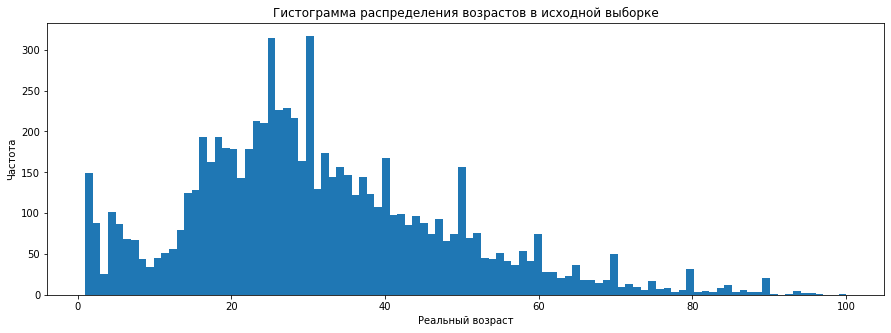

In [8]:
ax = (df['real_age']
                    .plot(
                       kind='hist', bins=100, title='Гистограмма распределения возрастов в исходной выборке', figsize=(15,5))
                );
ax.set_xlabel('Реальный возраст');
ax.set_ylabel('Частота');

Оценим статистические параметры возраста:

In [9]:
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Значения возраста в диапазоне от 60 и старше (за исключением локальных пиков) имеют мало изображений, что может сказаться на качестве определения людей пожилого возраста.Также есть локальные минимумы для возрастов 3 года и 9 лет.

Датасет с изображениями:

In [10]:
datagen = ImageDataGenerator(rescale=1./255)
data_gen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(288, 288),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


В папке 7591 изображение. Выведем 10 из них на экран.

Сформируем выборки с признаками и таргетом, а также посмотрим параметры батча:

In [11]:
x,y = next(data_gen_flow)
x.shape

(16, 288, 288, 3)

Батч состоит из 16 изображений с разрешением 224х224 и 3 слоями в соответствии с указанными параметрами для загрузчика данных.

Теперь выводим изображения:

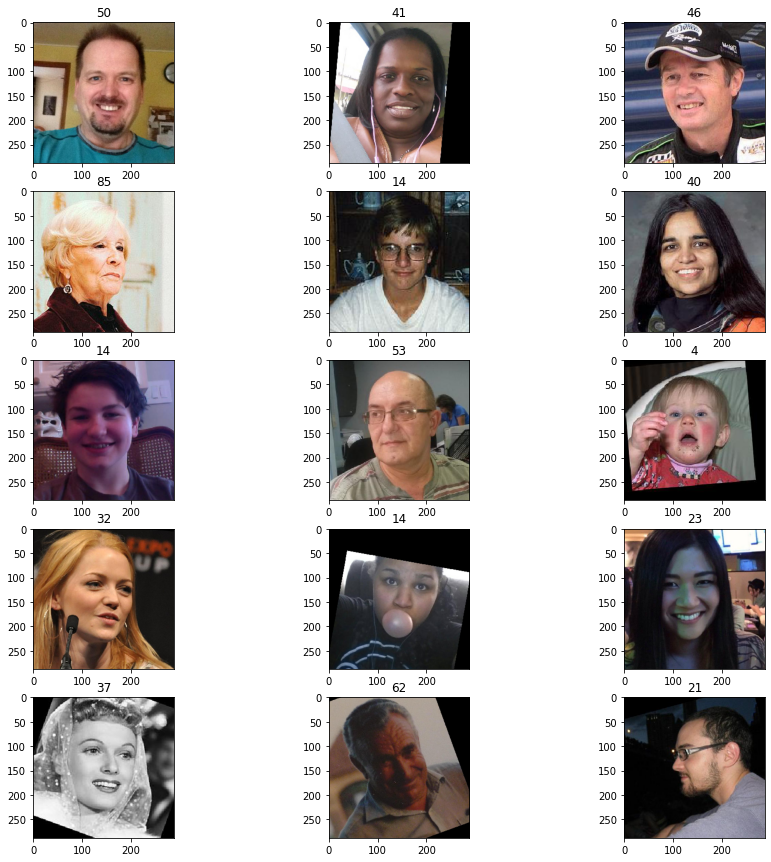

In [34]:
plt.figure(figsize=(15,15)) # specifying the overall grid size

for i in range(15):
    plt.subplot(5, 3, i + 1)
    plt.imshow(x[i, :288, :288, :3])
    plt.title(y[i])
plt.show()    

Размер изображений составляет 432х288 пикселей.

**Выводы по исследовательскому анализу**

- выяснили размер исходной выборки: 7591 объектов с названием файла изображения и реальным возрастом;
- дубликатов и пропусков не обнаружено;
- с учетом полученной гистограммы возраста видим, что значения возраста в диапазоне от 60 и старше (за исключением локальных пиков) имеют мало изображений, что может сказаться на качестве определения людей пожилого возраста.Также есть локальные минимумы для возрастов 3 года и 9 лет; 
- каждому объекту соответствует изображение 432х288 пикселей;
- есть цветные и чернобелые изображения, некоторые из них повернуты или сжаты по горизонтали. поэтому в лальнейшем имеет смысл использовать различные методы аугментации данных;
- размер изображений следует делать максимально возможным (288х288), поскольку чем больше пикселей, тем больше информации о признаках лиц мы будем использовать и соответственно тем лучшая метрика может быть получена при обучении модели.

## Обучение модели

**Код обучения модели**

```python

import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    df = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator( validation_split=0.25,                                       
                                        rescale=1/255.                                        
                                        )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=path+'final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(288, 288),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)    
    return train_datagen_flow

def load_test(path):

    df = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator( validation_split=0.25,                                       
                                        rescale=1/255.)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
    dataframe=df,
    directory=path+'final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(288, 288),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)    
    return test_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=(288, 288, 3),
                        weights='imagenet', 
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0005)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=7,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

**Результат вывода на экран**

```
Train for 178 steps, validate for 60 steps
Epoch 1/7
2023-06-03 16:23:23.252523: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-03 16:23:23.728722: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 88s - loss: 196.1292 - mae: 10.5320 - val_loss: 326.2346 - val_mae: 13.3681
Epoch 2/7
178/178 - 50s - loss: 99.9384 - mae: 7.5859 - val_loss: 302.2449 - val_mae: 12.9299
Epoch 3/7
178/178 - 74s - loss: 68.0542 - mae: 6.3178 - val_loss: 502.8417 - val_mae: 17.3676
Epoch 4/7
178/178 - 70s - loss: 48.4546 - mae: 5.4081 - val_loss: 253.8467 - val_mae: 11.7752
Epoch 5/7
178/178 - 59s - loss: 33.4726 - mae: 4.4581 - val_loss: 119.6176 - val_mae: 8.4931
Epoch 6/7
178/178 - 74s - loss: 24.3881 - mae: 3.8264 - val_loss: 119.2638 - val_mae: 8.8859
Epoch 7/7
178/178 - 57s - loss: 18.0582 - mae: 3.3045 - val_loss: 74.0828 - val_mae: 6.6340
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 74.0828 - mae: 6.6340
Test MAE: 6.6340

```

## Анализ обученной модели

Качество обучения модели зависит от множества параметров и с учетом ограниченных ресурсов однохначно определить зависимости, определяющие подходящие значения параметров было проблематично. В то же время получилось обучить несколько моделей с разными параметрами и сделать некоторые выводы:
- несмотря на наличие изображений с поворотом использование параметра rotation_range в диапазоне 10 - 45 не привело к улучшению значения целевой метрики, а также замедляло процесс обучения;параметры яркости и зума также не привели к улучшению значения целевой метрики;параметры вращения и сдвига также существенным образом не повлияли на качество модели. Можно предположить, что исходного количества признаков достаточно для нормального обучения модели;
- при значении шага оптимизатора Adam меньше 0.00001 целевая метрика ухудшалась, тоже можно сказать о значениях больше 0.001. В первом случае необходимо больше эпох, во втором - из-за большого шага можем пропускать верные решения;
- наличие дополнительного полносвязного слоя в "верхушке" модели ухудшает значение целевой метрики, возможно из-за того, что сеть сильно переобучается;
- увеличение размера батча с 16 до 32 улучшило метрику, что связано с улучшением обучения из-за большего объема данных;
- изменение размера изображений положительно сказалось на метрике, поскольку имеем большее признаковое пространство.

## Общие выводы:

Задачей выполнения проекта являлось построение и обучение свёрточной нейронной сети на датасете с фотографиями людей, для достижения метрики MAE на тестовой выборке не больше 8.

Для решения поставленной задачи:
1. Проведен исследовательский анализ исходных данных:

- выяснили размер исходной выборки: 7591 объектов с названием файла изображения и реальным возрастом;
- дубликатов и пропусков не обнаружено;
- с учетом полученной гистограммы возраста видим, что значения возраста в диапазоне от 60 и старше (за исключением локальных пиков) имеют мало изображений, что может сказаться на качестве определения людей пожилого возраста.Также есть локальные минимумы для возрастов 3 года и 9 лет;
- каждому объекту соответствует изображение 432х288 пикселей;
- есть цветные и чернобелые изображения, некоторые из них повернуты или сжаты по горизонтали. поэтому в лальнейшем имеет смысл использовать различные методы аугментации данных;
- размер изображений следует делать максимально возможным (288х288), поскольку чем больше пикселей, тем больше информации о признаках лиц мы будем использовать и соответственно тем лучшая метрика может быть получена при обучении модели.

2. На основе архитектуры ResNet50 создана и обучена модель сверточной нейронной сети:

- исходные датасеты разделены на обучающую и валидационную выборки в соотношении 3:1;
- при загрузке данных проведена нормализация значений пикселей, методы аугментации не применялись;
- сформированы батчи, состоящие из 16 изображений с изображениями 288х288 пикселей;
- для повышения скорости обучения модели использованы веса imagenet;
- "верхушка" модели изменена - использован один полносвязный слой с функцией активации relu;
- в качестве оптимизатора для градиентного спуска выбран Adam с шагом 0.0005;
- в качестве функции потерь выбрана функция mean_squared_error;
- обучение проводилось на 7 эпохах.

Цель проекта является достигнутой, создана и обучена модель свёрточной нейронной сети, которая обеспечивает значение метрики МАЕ = 6.63, что удовлетворяет требуемому ограничению МАЕ < 8. 

Некоторые направления улучшения качества модели:
    
   - дополнить исходную выборку для выравнивания гистограммы по возрастам;
   - пробовать разные значения параметров: шаг оптимизатора, количество нейронов в дополнительном слое;
   - пробовать разные методы аугментации;
   - использование методов борьбы с переобучением (напр., dropout);
   - использование других преобученных моделей;
   - исходя из статьи в теоретической части - важное значение имеет субъективная оценка возраста (или очевидный возраст), поэтому учитывая эту оценку при обучении можем дополнительно повысить качество модели.
